# Week 5 - Recurrent Neural Networks

In this lab, we will introduce different ways of learning from sequential data.

As a recurring example, we will train neural networks to do language modelling, i.e. predict the next token in a sentence. In the context of natural language processing a token could be a character or a word, but mind you that the concepts introduced here apply to all kinds of sequential data, such as e.g. protein sequences, weather measurements, audio signals, or videos, just to name a few.

To really get a grasp of what is going on inside a recurrent neural network (RNN), we will carry out a substantial part of this exercise in Nanograd rather than PyTorch. 

We start off with a simple toy problem, build an RNN using Nanograd, train it, and see for ourselves that it really works. Once we're convinced, you will implement the Long Short-Term Memory (LSTM) cell, also in Nanograd. 

This is *not* simple but with the DenseLayer class we already have, it is doable. Having done it yourself will help you understand what happens under the hood of the PyTorch code we will use throughout the course.

To summarize, in this notebook we will show you:
* How to represent sequences of categorical variables
* How to build and train an RNN in Nanograd
* How to build and train an LSTM network in Nanograd
* How to build and train an LSTM network in PyTorch


[Numpy version of the Notebook (previous version)](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Recurrent/OLD-5.1-Numpy-Recurrent-Neural-Networks.ipynb)

## Representing tokens or text

In previous labs we mainly considered data $x \in \mathbb{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathbb{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).

With RNNs, we can model both many-to-one functions: $\mathbb{R}^{t \, \times \, d} \rightarrow \mathbb{R}^c$ and many-to-many functions: $\mathbb{R}^{t \, \times \, d} \rightarrow \mathbb{R}^{t \, \times \, c}$, where $c$ is the amount of classes/output dimensions.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings. If you want to learn more about tokens, encodings and embeddings than what is covered in this exercise, we highly recommend [this lecture](https://www.youtube.com/watch?v=kEMJRjEdNzM&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a b EOS`,

`a a b b EOS`,

`a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given a sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$, and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will follow 5 `a`s.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [2]:
import numpy as np

# Set seed such that we always get the same dataset
# (this is a good idea in general)
np.random.seed(42)

def generate_dataset(num_sequences=2**5):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 4)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. <font color = 'blue'>Because RNN cannot understand words, but numbers. </font> We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `vocab_size` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

## Exercise a) Sequence to dictionary function 

Complete the sequences_to_dicts function below. You will need to fill the word_to_idx and idx_to_word dictionaries so that we can go back and forth between the two representations.

In [3]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        # YOUR CODE HERE!
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size # num_sentences == num_sequences 


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Consistency error: something went wrong in the conversion.'

We have 32 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


## Partitioning the dataset

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution, but mind you that this largely depends on the size of the dataset. Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [4]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 25 samples in the training set.
We have 3 samples in the validation set.
We have 3 samples in the test set.


When working with more complex data than what we use in this exercise, creating a PyTorch `DataLoader` on top of the dataset can be beneficial. A data loader is basically a fancy generator/iterator that we can use to abstract away all of the data handling and pre-processing + it's super useful for processing batches of data as well! Data loaders will come in handy later when you start to work on your projects, so be sure to check them out!

For more information on how to use datasets and data loaders in PyTorch, [consult the official guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## Nanograd utilities

We load necessary utility functions for the Nanograd library, which we saw in Lab 2.

In [5]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self):
        return self

    def sigmoid(self):
        return Var(0.5) * (Var(1.0) + (Var(0.5) * self).tanh()) # logistic function is a scaled and shifted version of tanh
    
    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1-tanh(self.v) ** 2)])

In [6]:
# convert from ndarray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y

# convert from Var to ndarray  
def Var_to_nparray(x):
    try:
        y = np.zeros((len(x),len(x[0])))
        for i in range(len(x)):
            for j in range(len(x[0])):
                y[i,j] = x[i][j].v
    except TypeError:
        y = np.zeros((len(x)))
        for i in range(len(x)):
            y[i] = x[i].v
    return y

# def Var_to_nparray(x):
#     y = np.zeros((len(x),len(x[0])))
#     for i in range(len(x)):
#         for j in range(len(x[0])):
#             y[i,j] = x[i][j].v
#     return y

In [7]:
class Initializer:
    def init_weights(self, n_in, n_out):
        raise NotImplementedError
    def init_bias(self, n_out):
        raise NotImplementedError

In [8]:
import random

class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(self.bias) for _ in range(n_out)]

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the entire vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [9]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.array([np.zeros(vocab_size)])
    
    # Set the appropriate element to one
    one_hot[0][idx] = 1.0
    return nparray_to_Var(one_hot)


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([Var_to_nparray(one_hot_encode(word_to_idx[word], vocab_size)) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[2], 1)
    return nparray_to_Var(encoding)

test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {Var_to_nparray(test_word).shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {Var_to_nparray(test_sentence).shape}.')

print(test_word)
print(test_sentence)

Our one-hot encoding of 'a' has shape (1, 4).
Our one-hot encoding of 'a b' has shape (2, 4).
[[Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]]
[[Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]]


In [10]:
encoded_training_set_x = []
encoded_training_set_y = []
encoded_validation_set_x = []
encoded_validation_set_y = []
encoded_test_set_x = []
encoded_test_set_y = []

for n in range(len(training_set)):
    encoded_training_set_x.append(one_hot_encode_sequence(training_set[n][0], vocab_size))
    encoded_training_set_y.append(one_hot_encode_sequence(training_set[n][1], vocab_size))
for n in range(len(validation_set)):
    encoded_validation_set_x.append(one_hot_encode_sequence(validation_set[n][0], vocab_size))
    encoded_validation_set_y.append(one_hot_encode_sequence(validation_set[n][1], vocab_size))
for n in range(len(test_set)):
    encoded_test_set_x.append(one_hot_encode_sequence(test_set[n][0], vocab_size))
    encoded_test_set_y.append(one_hot_encode_sequence(test_set[n][1], vocab_size))

Great! Now that we have our one-hot encodings in place, we can move on to the RNNs!

# Introduction to Recurrent Neural Networks (RNN)

Reading material: [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and (optionally) [this lecture](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

___

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ is a non-linear activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$

When we are doing language modelling using a cross-entropy loss, we additionally apply the softmax function to the output $o_{t}$:

- $\hat{y}_t = \mathrm{softmax}(o_{t})$


### Backpropagation through time

We define a loss function

- $E = \sum_t E_t  = \sum_t E_t(y_t ,\hat{y}_t ) \ , $

where $E_t(y_t ,\hat{y}_t )$ is the cross-entropy function.

Backpropagation through time amounts to computing the gradients of the loss using the same type of clever bookkeeping we applied to the feed-forward network in week 1. This you will do in Exercise D.

## Implementing an RNN

We will implement the forward pass, backward pass, optimization and training loop for an RNN in Nanograd so that you can get familiar with the recurrent nature of RNNs. Later, we will go back to PyTorch.

We define the Nanograd DenseLayer class from [lab 2](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.1-EXE-FNN-AutoDif-Nanograd.ipynb) with a few additions:
* the option `use_bias` to define a layer without bias. This is useful when we define the recurrent layer and
* a method `forward_sequence` which is useful when a DenseLayer is used as part of a recurrent neural network

In [11]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer(), use_bias=True):
        self.weights = initializer.init_weights(n_in, n_out)
        
        self.use_bias = use_bias # default = True
        if use_bias:
            self.bias = initializer.init_bias(n_out) 
        
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + (' Biases: ' + repr(self.bias) if self.use_bias else '')

    def parameters(self) -> Sequence[Var]:
        params = []
        for r in self.weights:
            params += r

        if self.use_bias:
            params += self.bias

        return params

    def forward(self, input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(input), "weights and input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] if self.use_bias else Var(0.0)
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(input)):
                node += input[i]*weights[i][j]
            node = self.act_fn(node)
            out.append(node)

        return out
    
    def forward_sequence(self, input: Sequence[Sequence[Var]]) -> Sequence[Sequence[Var]]:
        out = []
        for i in range(len(input)): 
            node = self.forward(input[i])
            out.append(node)
        return out
    
# in_hid_layer=DenseLayer(1, 5, lambda x: x, NormalInitializer())
# in_hid_layer.bias

## Exercise b) The RNNLayer class

Complete the RNNLayer class below.

Explain how we reuse the DenseLayer class.

Explain what the forward and the forward_sequence method do.

<font color = 'blue'>   
Ref.1: https://www.youtube.com/watch?v=qjrad0V0uJE

Ref.2: https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85


In [12]:
from typing import Sequence

class RNNLayer:
    def __init__(self, n_in: int, n_hid: int, act_fn, initializer = NormalInitializer(), initializer_hid = NormalInitializer()):
        self.n_hid = n_hid
        self.in_hid_layer = DenseLayer(n_in, n_hid, lambda x: x, initializer) # Uxt
        self.hid_hid_layer = DenseLayer(n_hid, n_hid, lambda x: x, initializer_hid, use_bias=False) # Vht-1 # we already get a bias through in_hid_layer        
        
        self.initial_hid = [Var(0.0) for _ in range(n_hid)] # initial hidden state
        self.stored_hid = [Var(0.0) for _ in range(n_hid)] 
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Feed-forward: ' + repr(self.in_hid_layer) + ' Recurrent: ' + repr(self.hid_hid_layer) + ' Initial hidden: ' + repr(self.initial_hid)

    def parameters(self) -> Sequence[Var]:      
        return self.in_hid_layer.parameters() + self.hid_hid_layer.parameters() + self.initial_hid

    def forward_step(self, input: Sequence[Var], input_hid: Sequence[Var]) -> Sequence[Var]:
        in_hids = self.in_hid_layer.forward(input)  # contribution from input Ux_t
        hid_hids = self.hid_hid_layer.forward(input_hid)  # contribution from hidden state
        
        hids = []
        for i in range(self.n_hid):
            hs = self.act_fn(in_hids[i]+hid_hids[i]) # f(Ux+Vh_(t-1))
            hids.append(hs) # hs == h_(t)
            
        return hids
    
    def forward_sequence(self, input: Sequence[Sequence[Var]], use_stored_hid = False) -> Sequence[Sequence[Var]]:
        out = []
        if use_stored_hid:
            hid = self.stored_hid
        else:
            hid = self.initial_hid
        # Takes a sequence and loops over each character in the sequence. Note that each character has dimension equal to the embedding dimension
        for i in range(len(input)):
            hid = self.forward_step(input[i],hid)
            out.append(hid)
        self.stored_hid = hid
        return out

Now we can define a network and pass some data through it.

In [13]:
NN = [
    RNNLayer(1, 5, lambda x: x.tanh()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward_batch(input: Sequence[Sequence[Sequence[Var]]], network, use_stored_hid=False):
    def forward_single_sequence(x, network, use_stored_hid):
        for layer in network:
            if isinstance(layer, RNNLayer):
                x = layer.forward_sequence(x, use_stored_hid) 
            else:
                x = layer.forward_sequence(x)
        return x

    output = [ forward_single_sequence(input[n], network, use_stored_hid) for n in range(len(input))]
    return output

print(NN[0])
x_train =[
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]],
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]]
          ]

output_train = forward_batch(x_train, NN)          
output_train[0][0][0].backward()

print(output_train)

Feed-forward: Weights: [[Var(v=0.1630, grad=0.0000), Var(v=0.1571, grad=0.0000), Var(v=-0.0691, grad=0.0000), Var(v=-0.0165, grad=0.0000), Var(v=0.0565, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] Recurrent: Weights: [[Var(v=0.0951, grad=0.0000), Var(v=0.0492, grad=0.0000), Var(v=-0.1571, grad=0.0000), Var(v=0.0370, grad=0.0000), Var(v=-0.1513, grad=0.0000)], [Var(v=-0.0249, grad=0.0000), Var(v=-0.1811, grad=0.0000), Var(v=-0.0689, grad=0.0000), Var(v=-0.0346, grad=0.0000), Var(v=-0.0277, grad=0.0000)], [Var(v=0.0544, grad=0.0000), Var(v=0.0733, grad=0.0000), Var(v=0.0460, grad=0.0000), Var(v=0.0048, grad=0.0000), Var(v=0.0900, grad=0.0000)], [Var(v=0.0492, grad=0.0000), Var(v=-0.0496, grad=0.0000), Var(v=0.0150, grad=0.0000), Var(v=-0.0093, grad=0.0000), Var(v=0.0487, grad=0.0000)], [Var(v=0.1279, grad=0.0000), Var(v=-0.1485, grad=0.0000), Var(v=0.1369, grad=0.0000),

## Exercise c) Unit test

Make unit tests to make sure that the output and the backward method work as it should.

NOTE: The .backward() call above simply backpropagates a value in the output (and not a loss). Below, we will extend our loss functions to be able to handle backpropagation through time.

Recycling code from [Lab 2](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.1-EXE-FNN-AutoDif-Nanograd.ipynb) is fine. 

In [14]:
NN = [
    RNNLayer(1, 3, lambda x: x.identity(), initializer = ConstantInitializer(), initializer_hid = ConstantInitializer()),
    DenseLayer(3, 1, lambda x: x.identity(), initializer = ConstantInitializer())
]

def forward_batch(input: Sequence[Sequence[Sequence[Var]]], network, use_stored_hid=False):
    def forward_single_sequence(x, network, use_stored_hid):
        for layer in network:
            if isinstance(layer, RNNLayer):
                x = layer.forward_sequence(x, use_stored_hid) 
            else:
                x = layer.forward_sequence(x)
        return x

    output = [ forward_single_sequence(input[n], network, use_stored_hid) for n in range(len(input))]
    return output

print(NN[0])
x_train =[
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]],
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]]
          ]

output_train = forward_batch(x_train, NN)          
output_train[0][0][0].backward()

print(output_train)

Feed-forward: Weights: [[Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] Recurrent: Weights: [[Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000)], [Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000)], [Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=1.0000, grad=0.0000)]] Initial hidden: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
[[[Var(v=3.0000, grad=1.0000)], [Var(v=15.0000, grad=0.0000)], [Var(v=54.0000, grad=0.0000)]], [[Var(v=3.0000, grad=0.0000)], [Var(v=15.0000, grad=0.0000)], [Var(v=54.0000, grad=0.0000)]]]


## Exercise d) Advanced initialization

How can we use He initialization for the recurrent layer?

Hint: the sum of two unit variance stochastic variables have variance 2.

Insert code for He initialization of the recurrent layer. Again, recycling code from Lab 2 is fine. 

In [15]:
## He
def DenseLayer_He_tanh(n_in: int, n_out: int):
#   std = 0.0 # <- replace with proper initialization 
    std = np.sqrt(1/n_in)
    return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise e) Sequence loss function

We want to solve a sequence to sequence problem. So you need a sequence loss function. 

Implement the function such that the sequence loss can take flexible input dimensions and so that it can take any loss as an argument, such as squared loss and cross entropy. (We recommend using cross entropy below)

We have provided a bit of code to try it out.

Hints: You can get inspiration from the forward_sequence method above. You can copy and paste squared loss and cross entropy from Lab 2. 

In [16]:
# Insert code here

def squared_loss_sequence(t, y):
    # add check that sizes agree
    assert len(t) == len(y), "training datas' and model's outputs must match in dimension"
    
    def squared_loss_single(t, y):
        # add check that sizes agree
        assert len(t) == len(y)
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += (t[i]-y[i]) ** 2
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += squared_loss_single(t[n],y[n])
    return Loss


def cross_entropy_loss_sequence(t, y):
    # add check that sizes agree
    assert len(t) == len(y)
    def cross_entropy_loss_single(t, y):
        assert len(t)==len(y), "one-hot encodings have different shapes"
        Loss = Var(0.0)
        denominator = Var(0.0)
        
        for i in range(len(t)): # sum over one-hot-encoding of character
            denominator += t[i].exp()
        
        for i in range(len(t)): # sum over one-hot-encoding of character
            t_softmax = t[i].exp() / denominator
            Loss += -y[i]*(t_softmax+Var(0.001)).log()
        return Loss
    
    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        for i in range(len(t[n])): # sum over characters in output sequence
            Loss += cross_entropy_loss_single(t[n][i],y[n][i])
    return Loss

def sequence_loss(t: Sequence[Sequence[Var]], y: Sequence[Sequence[Var]], loss_fn=cross_entropy_loss_sequence) -> Var:
    assert len(t) == len(y)
    return loss_fn(t, y)


# Test of loss func
NN = [
    RNNLayer(4, 2, lambda x: x.tanh()),
    DenseLayer(2, 4, lambda x: x.identity())
]

output_train = forward_batch(encoded_training_set_x[:3], NN)
print(output_train)       
loss = sequence_loss(output_train, encoded_training_set_y[:3], cross_entropy_loss_sequence)
print("Loss:", loss)
loss.backward()

print("Output:", output_train)

print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
    params = []
    for layer in range(len(network)):
        params += network[layer].parameters()
    return params

def update_parameters(params, learning_rate=0.01):
    for p in params:
        p.v -= learning_rate*p.grad

def zero_gradients(params):
    for p in params:
        p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

[[[Var(v=-0.0166, grad=0.0000), Var(v=-0.0034, grad=0.0000), Var(v=-0.0230, grad=0.0000), Var(v=-0.0173, grad=0.0000)], [Var(v=-0.0157, grad=0.0000), Var(v=-0.0052, grad=0.0000), Var(v=-0.0253, grad=0.0000), Var(v=-0.0157, grad=0.0000)], [Var(v=-0.0157, grad=0.0000), Var(v=-0.0052, grad=0.0000), Var(v=-0.0254, grad=0.0000), Var(v=-0.0158, grad=0.0000)], [Var(v=-0.0175, grad=0.0000), Var(v=0.0081, grad=0.0000), Var(v=-0.0039, grad=0.0000), Var(v=-0.0220, grad=0.0000)], [Var(v=-0.0174, grad=0.0000), Var(v=0.0085, grad=0.0000), Var(v=-0.0031, grad=0.0000), Var(v=-0.0221, grad=0.0000)], [Var(v=-0.0174, grad=0.0000), Var(v=0.0086, grad=0.0000), Var(v=-0.0030, grad=0.0000), Var(v=-0.0221, grad=0.0000)]], [[Var(v=-0.0166, grad=0.0000), Var(v=-0.0034, grad=0.0000), Var(v=-0.0230, grad=0.0000), Var(v=-0.0173, grad=0.0000)], [Var(v=-0.0175, grad=0.0000), Var(v=0.0081, grad=0.0000), Var(v=-0.0039, grad=0.0000), Var(v=-0.0220, grad=0.0000)]], [[Var(v=-0.0166, grad=0.0000), Var(v=-0.0034, grad=0.00

[None, None]

# Backpropagation through time 

Since we have automatic differentiation we don't have to code the backpropagation rule by hand. Just to give you a bit of appreciation for have much bookkeeping is necessary we have given the derivation belwo.

We need to compute the partial derivatives
$
\frac{\partial E}{\partial W},~\frac{\partial E}{\partial U},~\frac{\partial E}{\partial V}
$. 
We repeat the definition of the RNN forward pass from above:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$
- $\hat{y}_t = \mathrm{softmax}(o_{t})$

where
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output), and
- $h$ is the hidden state (the network's memory) for a given time step.

Recall though, that RNNs are recurrent and the weights $W,~U,~V$ are shared across time, i.e. we do not have separate weights for each time step. Therefore, to compute e.g. the partial derivative $\frac{\partial E}{\partial W}$, we need to 1) sum up across time, and 2) apply the chain rule:

$$\frac{\partial E}{\partial W} = \sum_{t} \frac{\partial E}{\partial o_{t}} \frac{\partial o_{t}}{\partial W}\,.$$
To compute$\frac{\partial o_{t}}{\partial W}$ we use the definition of $o_t$ above.
From week 1 (exercise i) we have that
$$\delta_{o,t} \equiv \frac{\partial E}{\partial o_{t}} = \frac{\partial E_t}{\partial o_{t}} = \hat{y}_{t} - y_{t}\,,$$
where $\hat{y}_{t}$ is a softmax distribution over model outputs $o_{t}$ at time $t$, and $y_{t}$ is the target label at time $t$. 

To compute $\frac{\partial E}{\partial U}$ and $\frac{\partial E}{\partial V}$ we again sum over time and use the chain rule:
$$
\frac{\partial E}{\partial U} = \sum_{t} \frac{\partial E}{\partial h_{t}} \frac{\partial h_{t}}{\partial U} \ . 
$$
This leads us to introduce
$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} \ .
$$
The backpropagation through time recursion is derived by realising that a variation of $h_t$ affects 1) the loss at time step $t$ through the feed-forward connection to the output and 2) the future losses through the $h_{t+1}$ dependence of $h_t$. Mathematically, we write this through the chain rule:

$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} =  \frac{\partial E}{\partial o_{t}} \frac{\partial o_t}{\partial h_{t}} + \frac{\partial E}{\partial h_{t+1}}
\frac{\partial h_{t+1}}{\partial h_{t}} = \delta_{o,t} \frac{\partial o_t}{\partial h_{t}} + \delta_{h,t+1}
\frac{\partial h_{t+1}}{\partial h_{t}} \ . 
$$

Like above we can compute $\frac{\partial h_{t+1}}{\partial h_{t}}$ using the definition of the network (shifted one time step). In the code the intermediate steps to compute the $\delta$ recursions have been precomputed for you. 

For more information on backpropagation through time see the [Deep learning book section 10.2.2](https://www.deeplearningbook.org/contents/rnn.html).


# Exercise f) Complete the training loop

Complete the training loop above and run the training. You can leave the hyper-parameters and network size unchanged.

Note that despite the small size of the network and dataset, training still takes quite a while. This is an issue with the recurrent structure of Nanograd. Using PyTorch, we would be able to use much larger datasets and models. We will attempt that in the bottom of the notebook. For now, you should get a feel of the recurrent structure of the RNN under the hood.

In [17]:
# Initialize training hyperparameters
EPOCHS = 200  
LR = 1e-2         # learning rate
LR_DECAY = 0.995  # decay in the learning rate

   0 ( 0.00%) Train loss: 128.233 	 Validation loss: 12.575
   5 ( 2.50%) Train loss: 110.139 	 Validation loss: 10.806
  10 ( 5.00%) Train loss: 93.244 	 Validation loss: 9.249
  15 ( 7.50%) Train loss: 79.453 	 Validation loss: 8.141
  20 (10.00%) Train loss: 73.737 	 Validation loss: 7.880
  25 (12.50%) Train loss: 71.084 	 Validation loss: 7.796
  30 (15.00%) Train loss: 68.990 	 Validation loss: 7.619
  35 (17.50%) Train loss: 65.204 	 Validation loss: 7.048
  40 (20.00%) Train loss: 60.938 	 Validation loss: 6.319
  45 (22.50%) Train loss: 48.891 	 Validation loss: 5.479
  50 (25.00%) Train loss: 52.443 	 Validation loss: 5.659
  55 (27.50%) Train loss: 51.635 	 Validation loss: 5.513
  60 (30.00%) Train loss: 52.385 	 Validation loss: 5.504
  65 (32.50%) Train loss: 42.789 	 Validation loss: 5.355
  70 (35.00%) Train loss: 49.856 	 Validation loss: 5.266
  75 (37.50%) Train loss: 43.603 	 Validation loss: 5.226
  80 (40.00%) Train loss: 52.767 	 Validation loss: 5.230
  85 (42.5

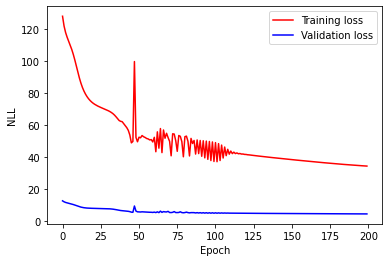

In [18]:
train_loss = []
val_loss = []

batch_size = 8

for e in range(EPOCHS):
    for b in range(int(np.ceil(len(encoded_training_set_x)/batch_size))):
        # Forward pass and loss computation
        output_train = forward_batch(encoded_training_set_x[b*batch_size:(b+1)*batch_size], NN) # note: batch_size    
        Loss = sequence_loss(output_train, encoded_training_set_y[b*batch_size:(b+1)*batch_size], cross_entropy_loss_sequence)
        
        # Backward pass
        Loss.backward()
        
        # gradient descent update
        update_parameters(parameters(NN), LR)
        zero_gradients(parameters(NN))           
    LR = LR * LR_DECAY
   
    # Training loss
    output_training = forward_batch(encoded_training_set_x, NN)
    Loss = sequence_loss(output_training, encoded_training_set_y, cross_entropy_loss_sequence)
    train_loss.append(Loss.v)
    
        
    # Validation loss 
    output_validation = forward_batch(encoded_validation_set_x, NN)        
    Loss_validation = sequence_loss(output_validation, encoded_validation_set_y, cross_entropy_loss_sequence)
    val_loss.append(Loss_validation.v)
    
    
    if e%5==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [19]:
# Get first sentence in test set
inputs, targets = test_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Forward pass
outputs = forward_batch(encoded_test_set_x[:1], NN) # predict sentense

output_sentence = [idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])] 

print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])])

Input sentence:
['a', 'a', 'a', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['a', 'b', 'b', 'b', 'b', 'EOS']


## Exercise g) Extrapolation

Now that we have trained an RNN, it's time to put it to test. We will provide the network with a starting sentence and let it `freestyle` from there!

How well does your RNN extrapolate -- does it work as expected? Are there any imperfections? If yes, why could that be?

In [20]:
def freestyle(NN, sentence='', num_generate=10):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    output_sentence = sentence
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)

    # Begin predicting
    outputs = forward_batch([sentence_one_hot], NN, use_stored_hid=False)
    output_words = [idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])]
    word = output_words[-1]

    # Append first prediction
    output_sentence.append(word)

    # Forward pass - Insert code here!
    if word != 'EOS':
        for i in range(num_generate-1):
            sentence_one_hot = one_hot_encode_sequence(output_sentence, vocab_size) # here shall be `output_sentence` not `sentence`
            outputs = forward_batch([sentence_one_hot], NN, use_stored_hid=False)
            output_words = [idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])]
            word = output_words[-1]
            output_sentence.append(word)
            if word == 'EOS':
                break
       
    return output_sentence


# Perform freestyle (extrapolation)
test_examples = ['a a b', 'a a a a b', 'a a a a a a b', 'a', 'r n n']
for i, test_example in enumerate(test_examples):
    print(f'Example {i}:', test_example)
    print('Predicted sequence:', freestyle(NN, sentence=test_example), end='\n\n')

Example 0: a a b
Predicted sequence: ['a', 'a', 'b', 'b', 'EOS']

Example 1: a a a a b
Predicted sequence: ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'EOS']

Example 2: a a a a a a b
Predicted sequence: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'EOS']

Example 3: a
Predicted sequence: ['a', 'a', 'b', 'b', 'EOS']

Example 4: r n n
Predicted sequence: ['r', 'n', 'n', 'b', 'EOS']



# Introduction to the Long Short-Term Memory (LSTM) Cell

Reading material: [Christopher Olah's walk-through](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

___


A vanilla RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the Long Short-Term Memory (LSTM) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. In this exercise, we will focus on LSTM but you would easily be able to go ahead and implement the GRU as well based on the principles that you learn here.

Below is a figure of the LSTM cell:

![lstm](https://i.imgur.com/3VkmUCe.png)
Source: https://arxiv.org/abs/1412.7828


The LSTM cell contains three gates, input, forget, output gates and a memory cell.
The output of the LSTM unit is computed with the following functions, where $\sigma = \mathrm{sigmoid}$.
We have input gate $i$, forget gate $f$, and output gate $o$ defines as

- $i = \sigma ( W^i [h_{t-1}, x_t])$

- $f = \sigma ( W^f [h_{t-1},x_t])$

- $o = \sigma ( W^o [h_{t-1},x_t])$

where $W^i, W^f, W^o$ are weight matrices applied to a concatenated $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)  for each respective gate.

$h_{t-1}$, from the previous time step along with the current input $x_t$ are used to compute the a candidate $g$

- $g = \mathrm{tanh}( W^g [h_{t-1}, x_t])$

The value of the cell's memory, $c_t$, is updated as

- $c_t = c_{t-1} \circ f + g \circ i$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication (hint: element-wise multiplication is computed with the `*` operator in numpy).

The output, $h_t$, is computed as

- $h_t = \mathrm{tanh}(c_t) \circ o$

and it is used for both the timestep's output and the next timestep, whereas $c_t$ is exclusively sent to the next timestep.
This makes $c_t$ a memory feature, and is not used directly to compute the output of the timestep.

## Exercise h) Make the LSTMLayer class

Make the LSTM class.

In [21]:
# Insert code here

class LSTMLayer:
    def __init__(self, n_in: int, n_hid: int, act_fn, initializer = NormalInitializer(), initializer_hid = NormalInitializer()):
        self.n_in = n_in     # num of inputs
        self.n_hid = n_hid   # num of hidden states
        
        self.in_hid_layer = DenseLayer(n_in, n_hid, lambda x: x, initializer)
        self.g_layer = DenseLayer(n_in, n_hid, lambda x: x.tanh(), initializer) # tanh (Wg[h,x]) t-1, t
        self.i_layer = DenseLayer(n_in, n_hid, lambda x: x.sigmoid(), initializer) # sigmoid (Wi)
        self.f_layer = DenseLayer(n_in, n_hid, lambda x: x.sigmoid(), initializer) # sigmoid (Wf)
        self.o_layer = DenseLayer(n_in, n_hid, lambda x: x.sigmoid(), initializer) # sigmoid (Wo)
        
        self.initial_hid = [Var(0.0) for _ in range(n_hid)]
        self.stored_hid = [Var(0.0) for _ in range(n_hid)]
        self.initial_c = [Var(0.0) for _ in range(n_hid)]
        self.stored_c = [Var(0.0) for _ in range(n_hid)]
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Feed-forward: ' + repr(self.in_hid_layer) + ' Candidate: ' + repr(self.g_layer) + ' i gate ' + repr(self.i_layer) + ' f gate ' + repr(self.f_layer) + ' o gate ' + repr(self.o_layer) + ' Initial hidden: ' + repr(self.initial_hid)

    def parameters(self) -> Sequence[Var]:      
        return self.in_hid_layer.parameters() + self.g_layer.parameters() + self.i_layer.parameters() + self.f_layer.parameters() + self.o_layer.parameters() + self.initial_hid

    def forward_step(self, input: Sequence[Var], input_hid: Sequence[Var], input_c: Sequence[Var]) -> Sequence[Var]:
        hids = []
        cs = []
        concatenated_input = []
        for val in input_hid:
            concatenated_input.append(val)
        for val in input:
            concatenated_input.append(val)

        g = self.g_layer.forward(concatenated_input)
        i = self.i_layer.forward(concatenated_input)
        f = self.f_layer.forward(concatenated_input)
        o = self.o_layer.forward(concatenated_input)


#         for j in range(self.n_hid):
#             g[j] = g[j].sigmoid()  # ===> tanh()
#             i[j] = i[j].sigmoid()
#             f[j] = f[j].sigmoid()
#             o[j] = o[j].tanh()  # ===> sigmoid()

        for n in range(self.n_hid):
            c = input_c[n]*f[n]+g[n]*i[n] # input_c == c intitial
            h = self.act_fn(c)*o[n]
            cs.append(c)
            hids.append(h)

        return hids, cs

    
    def forward_sequence(self, input: Sequence[Sequence[Var]], use_stored_hid = False) -> Sequence[Sequence[Var]]:
        out = []
        if use_stored_hid:
            hid = self.stored_hid
            c = self.stored_c
        else:
            hid = self.initial_hid
            c = self.initial_c
        # Takes a sequence and loops over each character in the sequence. Note that each character has dimenson equal to the embeddng dimenson
        for i in range(len(input)):
            hid, c = self.initial_hid, self.initial_c 
#             hid, c = self.forward_step(input[i], hid, c) 
            out.append(hid)
        self.stored_hid = hid
        self.stored_c = c
        return out

Here is a bit of code to test it out:

In [22]:
NN = [
    LSTMLayer(1, 5, lambda x: x.tanh()),
    DenseLayer(5, 1, lambda x: x.identity())
]

print(NN[0])
x_train =[[[Var(1.0)], [Var(2.0)], [Var(3.0)]],
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]]]

output_train = forward_batch(x_train, NN)          
# output_train[0][0][0].backward()

# print(output_train)

Feed-forward: Weights: [[Var(v=0.1164, grad=0.0000), Var(v=-0.1745, grad=0.0000), Var(v=0.0608, grad=0.0000), Var(v=-0.0194, grad=0.0000), Var(v=-0.0696, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] Candidate: Weights: [[Var(v=-0.0811, grad=0.0000), Var(v=-0.1288, grad=0.0000), Var(v=-0.3319, grad=0.0000), Var(v=0.0671, grad=0.0000), Var(v=0.1135, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] i gate Weights: [[Var(v=-0.0726, grad=0.0000), Var(v=0.1095, grad=0.0000), Var(v=-0.0428, grad=0.0000), Var(v=-0.0704, grad=0.0000), Var(v=0.1080, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] f gate Weights: [[Var(v=0.0916, grad=0.0000), Var(v=-0.2

## Exercise i) LSTM training

Complete the LSTM training loop

Run the training loop. Training time in Nanograd will likely be long, but see if you can find settings to compare your LSTM learning curve (NLL and number of epochs) to the vanilla RNN from earlier. Do you observe any improvements? Motivate your answer.

Finally, below we will implement LSTM in PyTorch. You will notice it is much, much faster!

In [23]:
# Initialize training hyperparameters
EPOCHS = 200
LR = 1e-2 
LR_DECAY = 0.995

   0 ( 0.00%) Train loss: 130.270 	 Validation loss: 12.768
   5 ( 2.50%) Train loss: 114.758 	 Validation loss: 11.250
  10 ( 5.00%) Train loss: 111.346 	 Validation loss: 10.921
  15 ( 7.50%) Train loss: 109.741 	 Validation loss: 10.767
  20 (10.00%) Train loss: 108.804 	 Validation loss: 10.676
  25 (12.50%) Train loss: 108.193 	 Validation loss: 10.616
  30 (15.00%) Train loss: 107.766 	 Validation loss: 10.575
  35 (17.50%) Train loss: 107.453 	 Validation loss: 10.545
  40 (20.00%) Train loss: 107.215 	 Validation loss: 10.522
  45 (22.50%) Train loss: 107.029 	 Validation loss: 10.504
  50 (25.00%) Train loss: 106.881 	 Validation loss: 10.489
  55 (27.50%) Train loss: 106.760 	 Validation loss: 10.478
  60 (30.00%) Train loss: 106.661 	 Validation loss: 10.468
  65 (32.50%) Train loss: 106.578 	 Validation loss: 10.460
  70 (35.00%) Train loss: 106.508 	 Validation loss: 10.454
  75 (37.50%) Train loss: 106.448 	 Validation loss: 10.448
  80 (40.00%) Train loss: 106.396 	 Vali

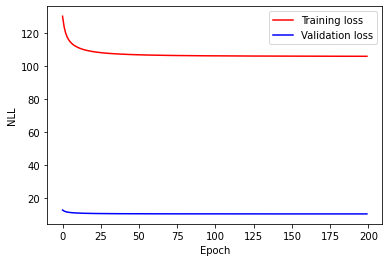

In [24]:
NN = [
    LSTMLayer(4, 1, lambda x: x.tanh()),
    DenseLayer(1, 4, lambda x: x.identity())
]

train_loss = []
val_loss = []

batch_size = 8

for e in range(EPOCHS):
    for b in range(int(np.ceil(len(encoded_training_set_x)/batch_size))):
           # Forward pass and loss computation
        output_train = forward_batch(encoded_training_set_x[b*batch_size:(b+1)*batch_size], NN) # note: batch_size    
        Loss = sequence_loss(output_train, encoded_training_set_y[b*batch_size:(b+1)*batch_size], cross_entropy_loss_sequence)
        
        # Backward pass
        Loss.backward()
        
        # gradient descent update
        update_parameters(parameters(NN), LR)
        zero_gradients(parameters(NN))   
        
    LR = LR * LR_DECAY
   
    # Training loss
    output_training = forward_batch(encoded_training_set_x, NN)
    Loss = sequence_loss(output_training, encoded_training_set_y, cross_entropy_loss_sequence)
    train_loss.append(Loss.v)
    
        
    # Validation loss 
    output_validation = forward_batch(encoded_validation_set_x, NN)        
    Loss_validation = sequence_loss(output_validation, encoded_validation_set_y, cross_entropy_loss_sequence)
    val_loss.append(Loss_validation.v)
    
    if e%5==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# Plot training and validation loss
import matplotlib.pyplot as plt
%matplotlib inline
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## PyTorch implementation of the LSTM

Now that we know how the LSTM cell works, let's see how easy it is to use in PyTorch!

Definition of our LSTM network. We define a LSTM layer using the [nn.LSTM](https://pytorch.org/docs/stable/nn.html#lstm) class. The LSTM layer takes as argument the size of the input and the size of the hidden state like in our Nanograd implementation.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=50,
                          num_layers=1, batch_first=True)
        
        # Output layer
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (lstm): LSTM(4, 50, batch_first=True)
  (l_out): Linear(in_features=50, out_features=4, bias=False)
)


## Exercise j) Train in PyTorch

Define an LSTM for our recurrent neural network `MyRecurrentNet` above. A single LSTM layer is sufficient. What should the input size and hidden size be? Hint: use the PyTorch documentation.

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

Epoch 0, training loss: 1.3272954893112183, validation loss: 1.3741325934727986
Epoch 10, training loss: 0.6454292154312133, validation loss: 0.6993560194969177
Epoch 20, training loss: 0.37836830139160155, validation loss: 0.31168895959854126
Epoch 30, training loss: 0.3549323171377182, validation loss: 0.2867404818534851
Epoch 40, training loss: 0.3374921727180481, validation loss: 0.2457472284634908
Epoch 50, training loss: 0.33334227979183195, validation loss: 0.24412830670674643
Epoch 60, training loss: 0.33117273151874543, validation loss: 0.2428061713774999
Epoch 70, training loss: 0.3297879320383072, validation loss: 0.24186425904432932
Epoch 80, training loss: 0.32880797624588015, validation loss: 0.24116980532805124
Epoch 90, training loss: 0.328062629699707, validation loss: 0.24063444137573242
Epoch 100, training loss: 0.3274660015106201, validation loss: 0.24020688235759735
Epoch 110, training loss: 0.3269717538356781, validation loss: 0.23985664546489716
Epoch 120, traini

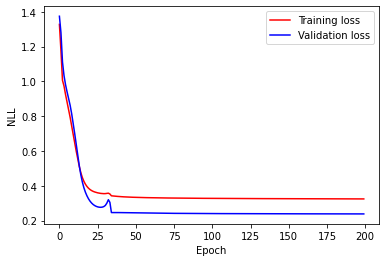

In [26]:
# Hyper-parameters
num_epochs = 200

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-6)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
#         inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = torch.Tensor([Var_to_nparray(inputs_one_hot)])
#         inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = net(inputs_one_hot) 
        
        # Compute loss
        # YOUR CODE HERE!
#         target_batch = targets
        loss = criterion(outputs, targets_idx)
        loss.backward()
        optimizer.step()
        
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor([Var_to_nparray(inputs_one_hot)])

#         inputs_one_hot = torch.Tensor(inputs_one_hot)
#         inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = net.forward(inputs_one_hot)
        
        # Compute loss
        # YOUR CODE HERE!
        optimizer.zero_grad()
        loss = criterion(outputs, targets_idx)
        loss.backward()
        optimizer.step()
        
        # Backward pass
        # YOUR CODE HERE!
        # zero grad, backward, step...
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor([Var_to_nparray(inputs_one_hot)])
# inputs_one_hot = torch.Tensor(inputs_one_hot)
# inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

# Exercise k) Compare PyTorch and Nanograd implementations

Compare the two implementations (in terms of predictive performance, training speed, etc.). Are they similar? How do they differ?


Try to play around with the choice of hyper-parameters, optimizer, and hidden dimensions. How much can you improve the negative log-likelihood by these simple changes?

<font color = 'blue'> From above results, we can see that PyTorch can have much better performance than using Nanograd method, such as lower validation loss and faster training speed. 

## Exercise l) Other RNN cells (optional)

Aside from the LSTM cell, various other RNN cells exist. The gated recurrent unit (GRU) is a variation of the LSTM cell that uses less gating mechanisms. Try to look it up in the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#gru) and switch out the LSTM cell in the code above. What do you notice in terms of performance and convergence speed?

## Exercise m) More complex tasks (optional)

Go back and generate a more complex patterned dataset to learn from. Do you see any significant differences between a vanilla RNN and LSTM (implemented in e.g. PyTorch) when you increase the difficulty of the task?

# It works, now what?

In this notebook you have learned how to use embeddings, recurrent neural networks, and the LSTM cell in particular.

As we have already seen, RNNs are excellent for sequential data such as language. But what do we do if we're modelling data with strong dependency in both directions? Like in many things deep learning, we can build powerful models by stacking layers on top of each other; *bi-directional* RNNs consist of two LSTM cells, one for each direction. A sequence is first fed into the forward LSTM cell and the reversed sequence is then used as input to the backward LSTM cell together with the last hidden state from the forward LSTM cell. Follow [this link](https://pdfs.semanticscholar.org/4b80/89bc9b49f84de43acc2eb8900035f7d492b2.pdf) for the original paper from 1997(!).

For even deeper representations, multiple layers of both uni-directional and bi-directional RNNs can be stacked ontop of each other, just like feed-forward and convolutional layers. For more information on this, check out the [LSTM PyTorch documentation](https://pytorch.org/docs/stable/nn.html#lstm). Next week we will also explore ways to combine RNNs with other types of layers for even more expressive function approximators.